In [1]:
#import all needed libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline


# FBI Gun Data Analysis

## Table of Content:
<ul>
<li><a href = '#introduction'>Introduction</a></li>
<ul>

<a id='introduction'></a>
## Introduction

This is a project based on the data from the FBI's National Instant Criminal Background Check System and the State level data from Census.gov.The orignal data can be found with files named 'gun_data.csv' and 'us.census data.csv' in the same repository. 



<a id = 'data_wrangling'></a>
## Data Wrangling

In [115]:
#show orginal data of 'us_census data.csv':
us_census_data = pd.read_csv('us_census data.csv')

In [116]:
#Drop the Fact Note column since it contains no useful information for analysis
us_census_data = us_census_data.drop(['Fact Note'], axis = 1)
#drop all the footnote and keep only the useful data with numbers values
us_census_data = us_census_data[:64] 
#Replace all Z,D and FN with 0 based on the footnote definition
us_census_data = us_census_data.replace({'Z':'0','D':'0','FN':'0'}) 
#Remove all ',', '%' and '$' in the dataframe
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].replace({',':'','%':'',r'\$':''},regex = True)
#Cast the each column's value to float data type
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].astype(float)


In [117]:
us_census_data.head(3)

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",4.8633e+06,741894,6.93107e+06,2.98825e+06,3.925e+07,5.54054e+06,3.57645e+06,952065,2.06124e+07,...,865454,6.65119e+06,2.78626e+07,3.05122e+06,624594,8.41181e+06,7.288e+06,1.8311e+06,5.77871e+06,585501
1,"Population estimates base, April 1, 2010, (V2...",4.78013e+06,710249,6.3923e+06,2.91602e+06,3.72545e+07,5.02932e+06,3.57411e+06,897936,1.88046e+07,...,814195,6.3463e+06,2.51461e+07,2.76389e+06,625741,8.00104e+06,6.72454e+06,1.85301e+06,5.68729e+06,563767
2,"Population, percent change - April 1, 2010 (es...",1.7,4.5,8.4,2.5,5.4,10.2,0.1,6,9.6,...,0.063,0.048,10.8,10.4,-0.2,5.1,8.4,-1.2,1.6,3.9


In [118]:
#read the original gun_data.csv 
fbi_gun_data = pd.read_csv('NICS_Firearm_Checks.csv') 

In [119]:
#fill NaN in the dataframe with 0
fbi_gun_data = fbi_gun_data.fillna(0) 
#Cast all values to float data type
fbi_gun_data.loc[:,'permit':'totals'] = fbi_gun_data.loc[:,'permit':'totals'].astype(float, inplace = True)
# convert the month column to datetime format
fbi_gun_data['month'] = pd.to_datetime(fbi_gun_data['month'])

In [120]:
fbi_gun_data.head(3)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09-01,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317.0,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019.0
1,2017-09-01,Alaska,209.0,2.0,2320.0,2930.0,219.0,160.0,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303.0
2,2017-09-01,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631.0,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394.0


In [121]:
# This data is pulled from https://www.gunviolencearchive.org/reports/mass-shooting?page=2&year=2016
gun_violence_2016 = pd.read_csv('gun_violence_2016.csv')
gun_violence_2016 = gun_violence_2016.drop('Operations', axis = 1).fillna(-1)
gun_violence_2016['Incident Date'] = pd.to_datetime(gun_violence_2016['Incident Date'])
gun_violence_2016 = gun_violence_2016.rename(columns = {"# Killed": "Killed", "# Injured": "Injured"})
gun_violence_2016['Total Casualty'] = gun_violence_2016['Killed'] + gun_violence_2016['Injured']


In [122]:
gun_violence_2016.head()

,Incident Date,State,City Or County,Address,Killed,Injured,Total Casualty
0,2016-12-31,Georgia,Lenox (El Dorado),27 Briarwood Ct,2,2,4
1,2016-12-31,Texas,Houston,3704 Fannin Street,1,3,4
2,2016-12-30,Ohio,Mansfield,3230 Possum Run Rd,0,5,5
3,2016-12-30,Connecticut,Wallingford,95 S Turnpike Rd,2,3,5
4,2016-12-28,Georgia,Columbus,2914 10th Street,1,4,5


<a id = 'exploratory_data_analysis'></a>
## Exploratory Data Analysis

## 1. Population for different states (Census 2010)
In this section we will investigate population at different individual states at year 2010 when the most recent census was done

In [196]:
#Loading the US map shapefile
map_path = "./us_states/tl_2017_us_state.shp"
usa = gpd.read_file(map_path)
#Drop non-state data
usa = usa.set_index('NAME').drop(['Guam','United States Virgin Islands','Commonwealth of the Northern Mariana Islands','American Samoa','District of Columbia','Puerto Rico'])


In [197]:
all_states_population = us_census_data.iloc[3]['Alabama':'Wyoming']
all_states_population = all_states_population.reset_index().rename(columns = {'index':'NAME',3:'Population'}).set_index('NAME')
usa = pd.concat([usa,all_states_population], axis = 1, sort = True)


Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census')

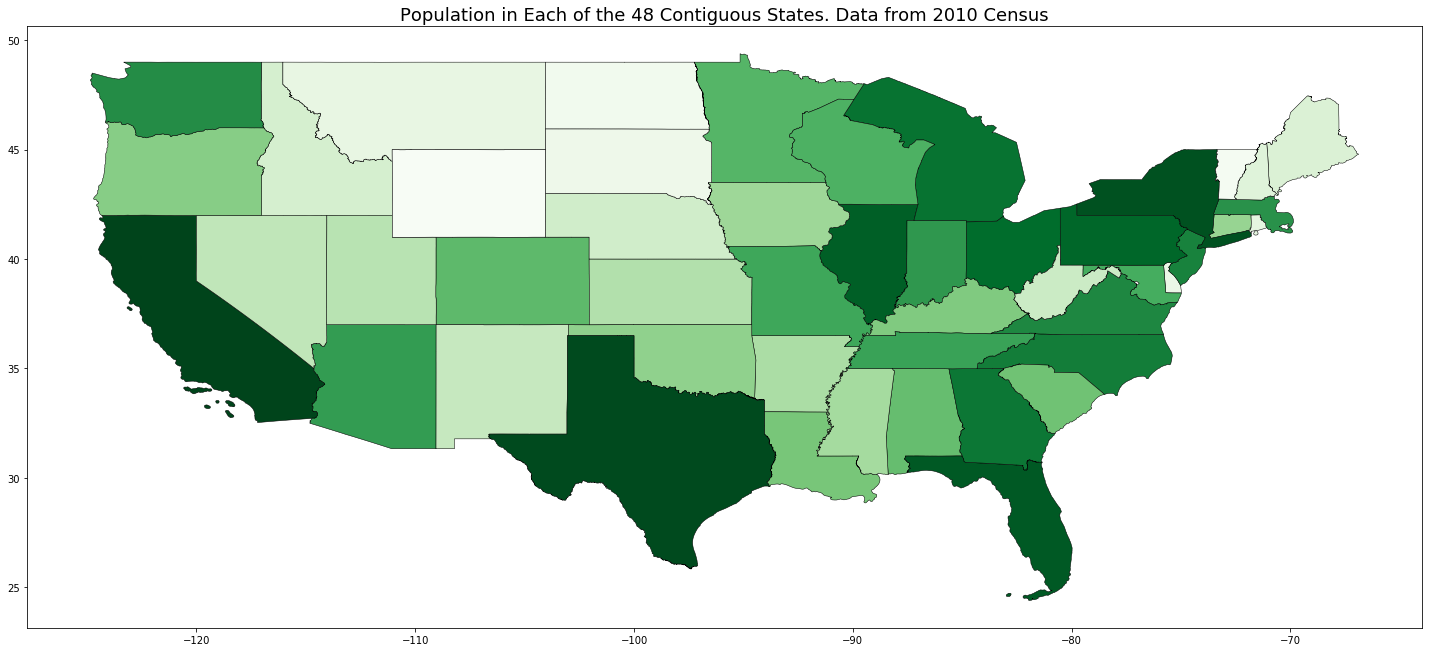

In [198]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Population', cmap = 'Greens', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census", fontsize = 18)


Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census')

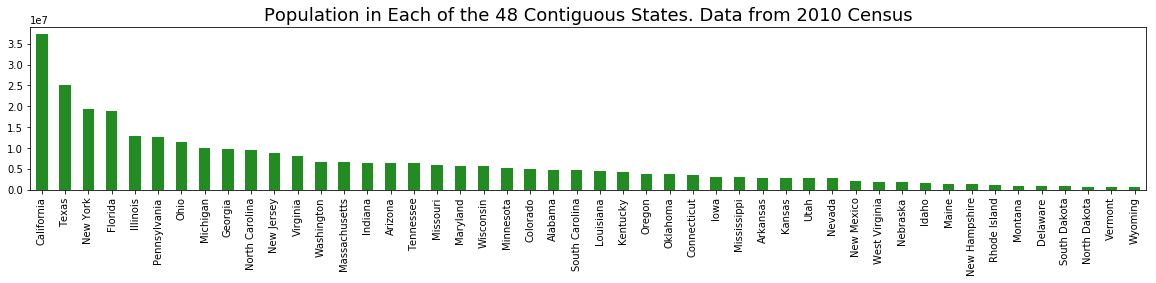

In [200]:
usa.drop(['Hawaii','Alaska'])['Population'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'forestgreen')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census", fontsize = 18)

## 1.2  Total Background Check Initiated at Different States (Year 2016)
In this section we will investigate total gun registration in different states at year 2016

In [201]:
#create a new column stores the information of year for each row
fbi_gun_data['year'] = fbi_gun_data['month'].dt.year

#select rows with year 2016 and group the data by states and calculae the sum of totals for the year
# also, drop all the non-state data
backgroundCheck_y2016 = fbi_gun_data.loc[fbi_gun_data['year'] == 2016].groupby('state')['totals'].sum().drop(index = ['District of Columbia','Guam','Mariana Islands','Puerto Rico','Virgin Islands'])

backgroundCheck_y2016 = backgroundCheck_y2016.reset_index().rename(columns = {'state':'NAME','totals':'Total Background Checks Initiated'}).set_index('NAME')

usa = pd.concat([usa,backgroundCheck_y2016], axis = 1, sort = True)

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase in 2016 - U.S. Area Map View')

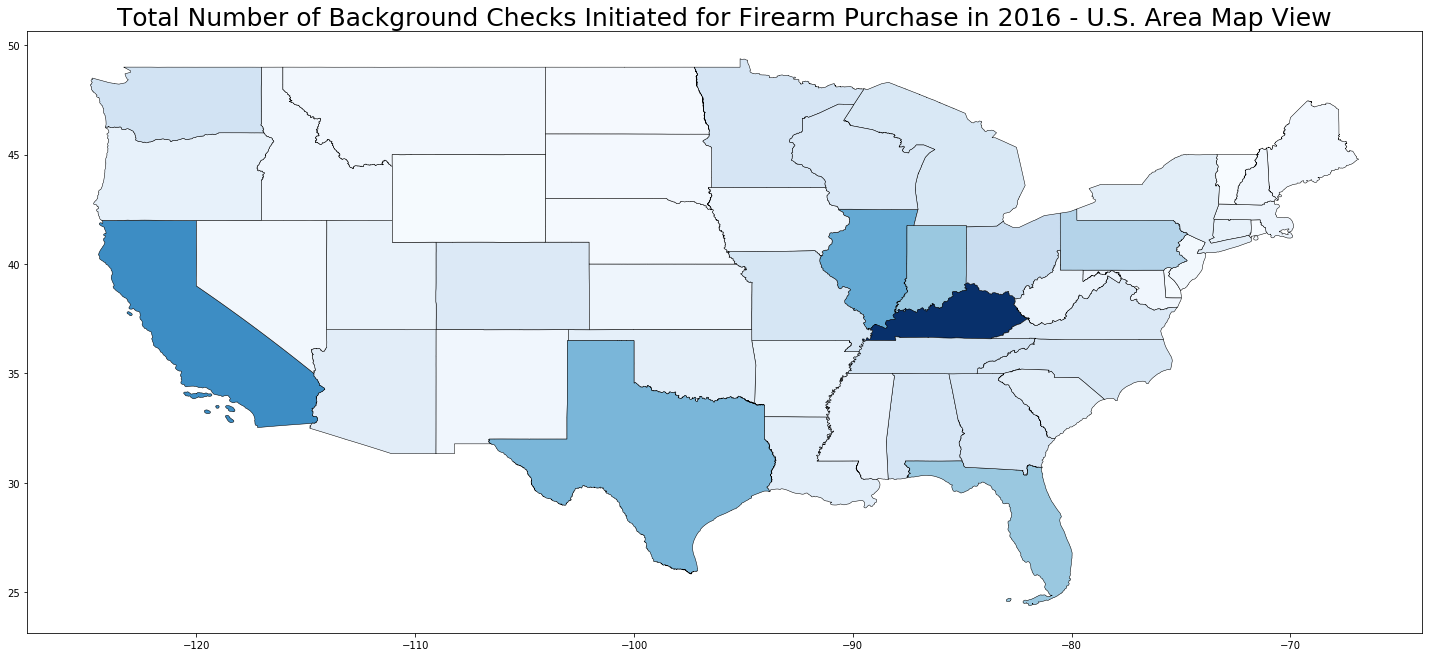

In [203]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Total Background Checks Initiated', cmap = 'Blues', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase in 2016 - U.S. Area Map View", fontsize = 25)



Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase in 2016')

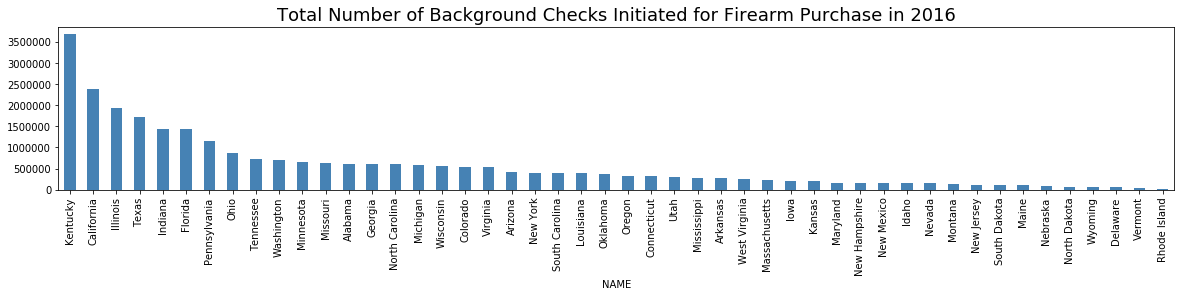

In [204]:
usa.drop(['Hawaii','Alaska'])['Total Background Checks Initiated'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'steelblue')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase in 2016", fontsize = 18)

Major findings: Kentucky has the highest number of gun registrations in all states in 2016.

## 1.3 Gun permits per person at different states
In this section we will investigate the gun per capita for different states at yeat 2010

In [205]:
usa['Gun Permits per person'] = (usa['Total Background Checks Initiated']/usa['Population'])*1000

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016, U.S. Map View')

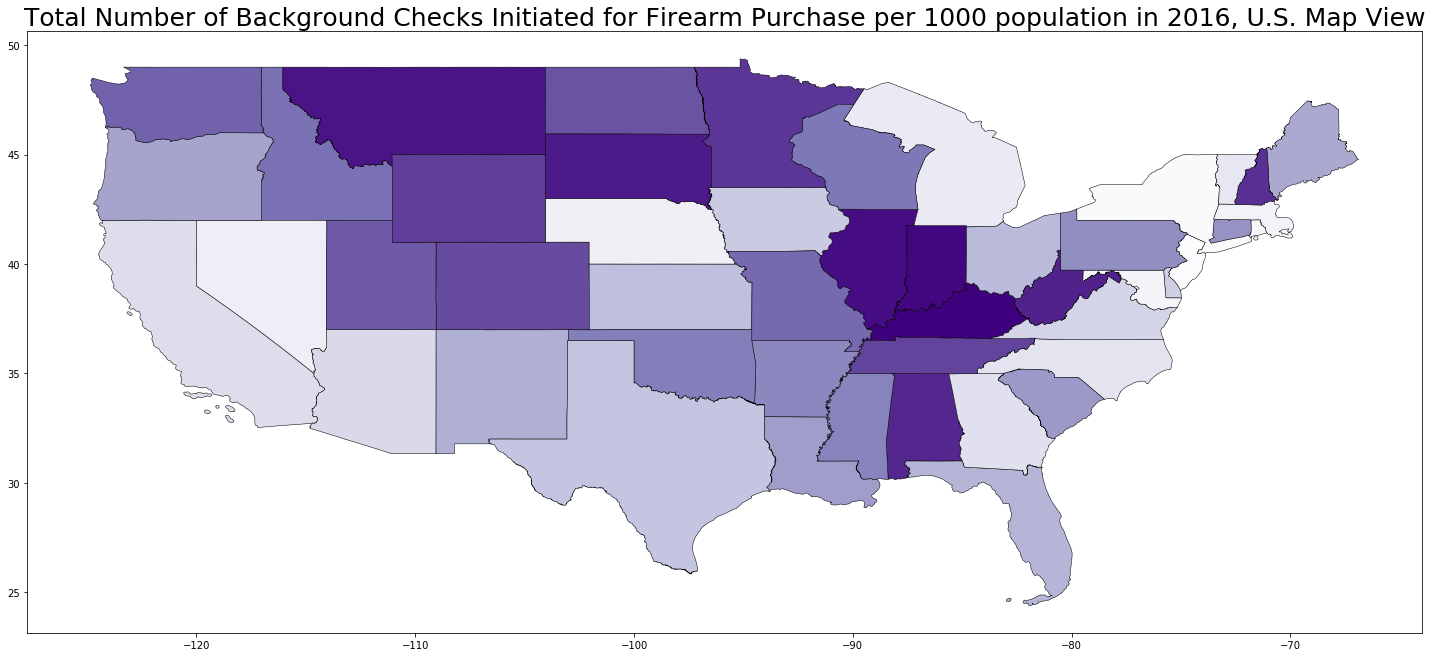

In [207]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Gun Permits per person', cmap = 'Purples', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016, U.S. Map View", fontsize = 25)

Text(0.5, 1.0, 'Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016')

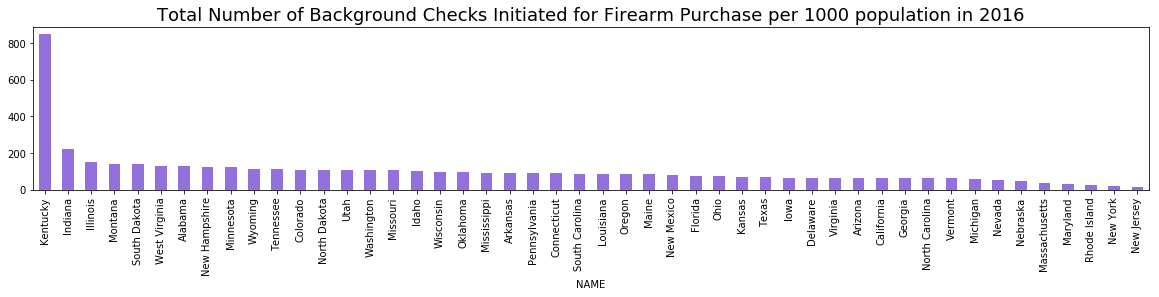

In [209]:
usa.drop(['Hawaii','Alaska'])['Gun Permits per person'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'mediumpurple')
plt.title("Total Number of Background Checks Initiated for Firearm Purchase per 1000 population in 2016", fontsize = 18)


Major findings: Kentucky has the highest per capita gun registration in all states in 2016

## 2.1 Change of Total Background Checks for Firearm Purchase for United States from 1999 - 2016 ( All States )
In this section we will look at the growth of total gun registration from 1999 to 2016 at national level

In [210]:
# Calculate the national total for different years pick only the data from 1999 to 2016\
# since they contain all months
permits_1999_to_2016 = fbi_gun_data.groupby(['year']).sum().iloc[1:-1]  
permits_1999_to_2016['total_million'] = (permits_1999_to_2016['totals']/1000000)

Text(0.5, 1.0, 'Change of National Total Background Checks for Firearm Purchase for United States from 1999 - 2016 (All States)')

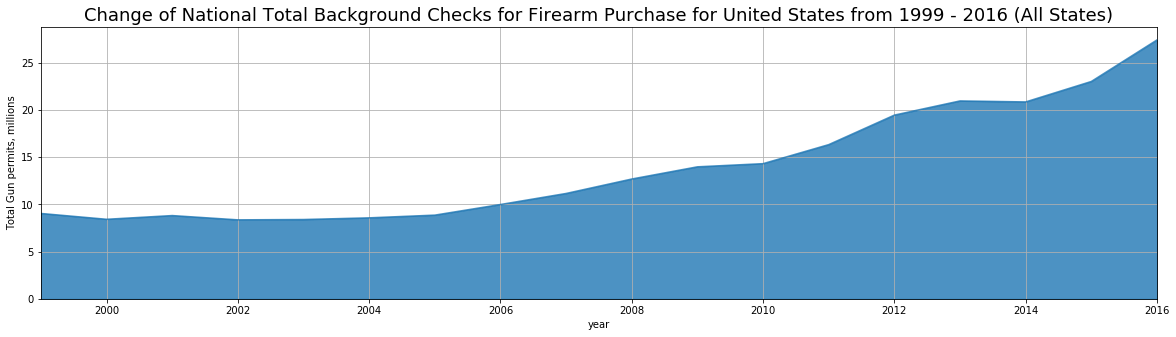

In [211]:
#plot the final result
permits_1999_to_2016['total_million'].plot(kind = 'area',figsize = (20,5),grid = True,alpha = 0.8).set(ylabel = 'Total Gun permits, millions')
plt.title('Change of National Total Background Checks for Firearm Purchase for United States from 1999 - 2016 (All States)', fontsize = 18)


Major findings: The total gun registration is increasing steadily from 1999 to 2016.  

## 2.2 Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016
In this section we will look at the growth of total gun registraion at state level from 1999 to 2016

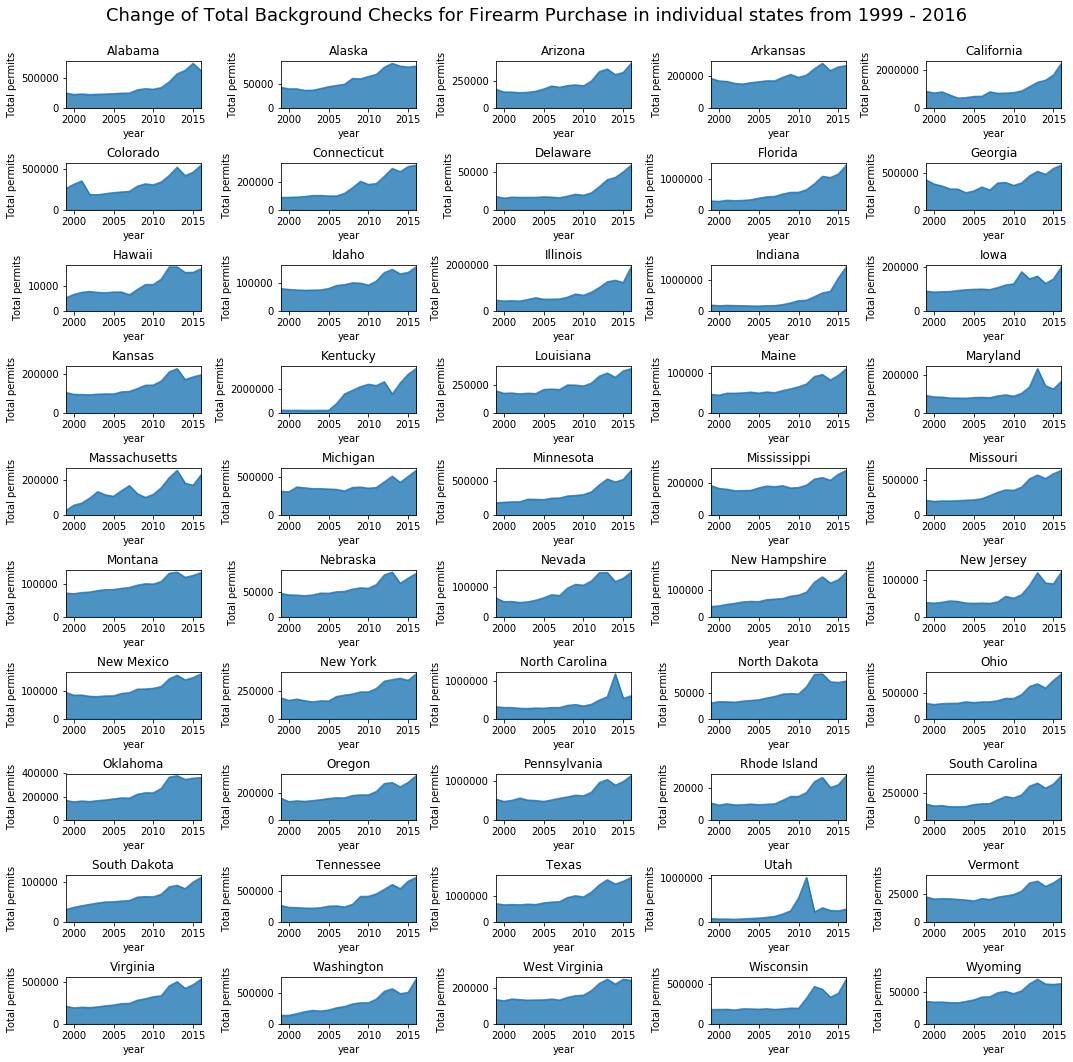

In [212]:
#create a figure with 50 empty subplot spots
fig, axes = plt.subplots(nrows=10, ncols=5) 
i = 0
k = 0

for state in us_census_data.drop(['Fact'], axis = 1).columns.tolist():
    if k <= 4:
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (15,15),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1 
    elif k > 4:
        # move the column to position 0
        k = 0
        # move the to next row
        i = i + 1
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (20,20),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1
        
plt.tight_layout()
fig.suptitle('Change of Total Background Checks for Firearm Purchase in individual states from 1999 - 2016',fontsize = 18)
fig.subplots_adjust(top=0.93)

Federal law requires criminal background checks for all firearm sales by licensed gun dealers to ensure that dealers do not sell guns to felons, domestic abusers, and other people prohibited from having them. However, federal law does not require background checks or any other process for firearms sold by unlicensed sellers.

## 3.1 Total Casualties of Gun Violence in 2016

In [213]:
gun_violence_2016.head()

,Incident Date,State,City Or County,Address,Killed,Injured,Total Casualty
0,2016-12-31,Georgia,Lenox (El Dorado),27 Briarwood Ct,2,2,4
1,2016-12-31,Texas,Houston,3704 Fannin Street,1,3,4
2,2016-12-30,Ohio,Mansfield,3230 Possum Run Rd,0,5,5
3,2016-12-30,Connecticut,Wallingford,95 S Turnpike Rd,2,3,5
4,2016-12-28,Georgia,Columbus,2914 10th Street,1,4,5


In [214]:
casualty_2016 = gun_violence_2016.groupby('State').sum()['Total Casualty']

In [215]:
casualty_2016 = casualty_2016.reset_index().rename(columns = {'State':'NAME'}).set_index('NAME')

In [216]:
usa = pd.concat([usa,casualty_2016], axis = 1, sort = True).fillna(0)

Text(0.5, 1.0, 'Casualties of Gun Violence of the 48 Contiguous States. 2016, U.S. Area Map View')

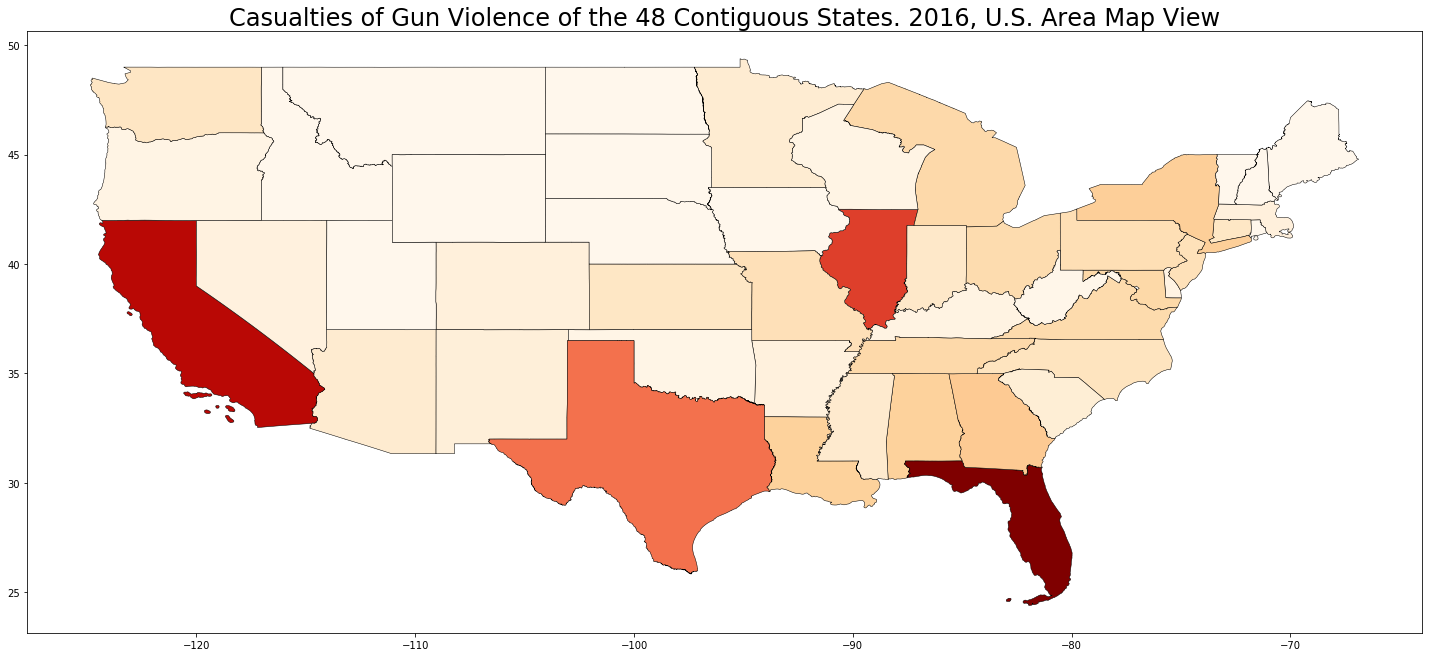

In [217]:
usa.drop(['Hawaii','Alaska','District of Columbia']).plot(column = 'Total Casualty', cmap = 'OrRd', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Casualties of Gun Violence of the 48 Contiguous States. 2016, U.S. Area Map View", fontsize = 24)

Text(0.5, 1.0, 'Casualties of Gun Violence of the 48 Contiguous States')

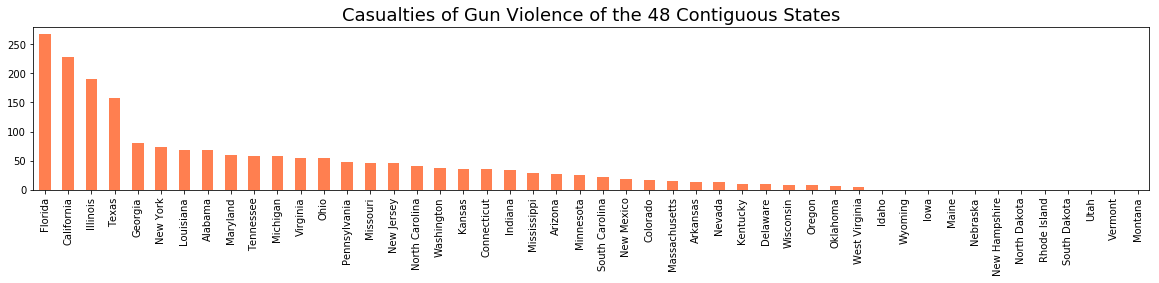

In [225]:
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'Coral')
plt.title("Casualties of Gun Violence of the 48 Contiguous States", fontsize = 18)

## 3.2 Total Casualties of Gun Violence in 2016 per Population

In [223]:
usa['Total Casualty Per Population'] = usa['Total Casualty']/usa['Population']*1000000

Text(0.5, 1.0, 'Casualties of Gun Violence Per Million Population of the 48 Contiguous States. 2016, U.S. Area Map View')

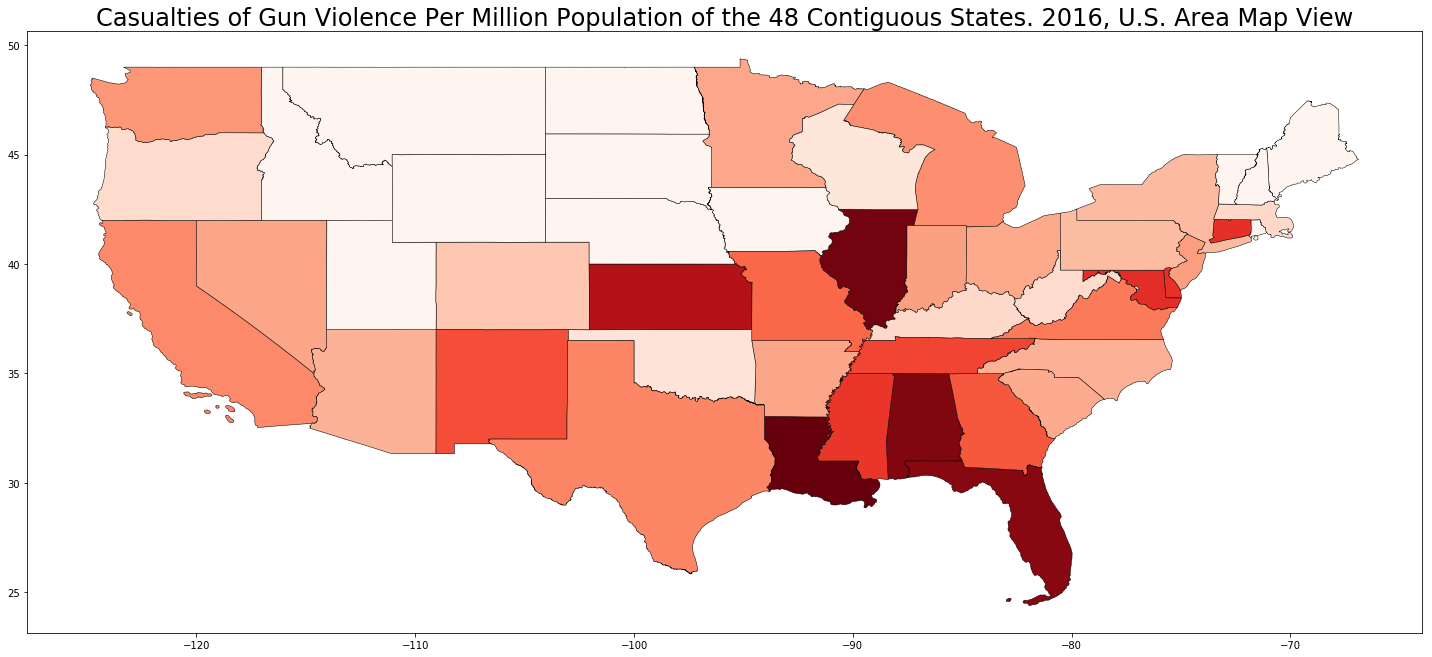

In [224]:
usa.drop(['Hawaii','Alaska','District of Columbia']).plot(column = 'Total Casualty Per Population', cmap = 'Reds', figsize = (25,15), linewidth = 0.5, edgecolor = 'k')
plt.title("Casualties of Gun Violence Per Million Population of the 48 Contiguous States. 2016, U.S. Area Map View", fontsize = 24)

Text(0.5, 1.0, 'Casualties of Gun Violence Per Million Population of the 48 Contiguous States')

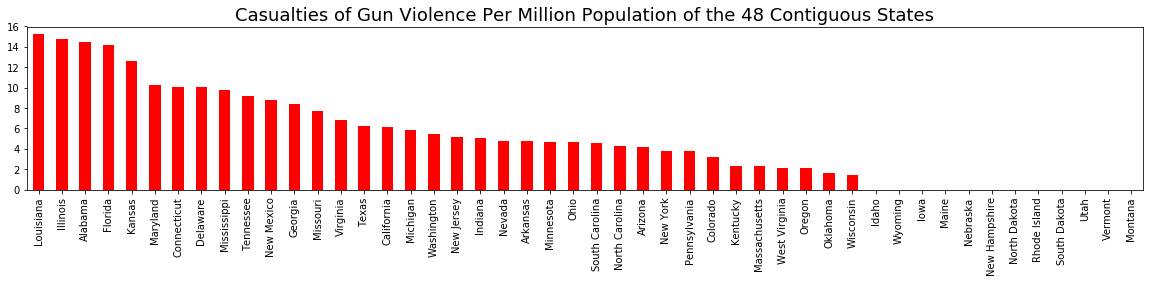

In [226]:
usa.drop(['Hawaii','Alaska','District of Columbia'])['Total Casualty Per Population'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'Red')
plt.title("Casualties of Gun Violence Per Million Population of the 48 Contiguous States", fontsize = 18)

In [227]:
us_census_data

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",4.8633e+06,741894,6.93107e+06,2.98825e+06,3.925e+07,5.54054e+06,3.57645e+06,952065,2.06124e+07,...,865454,6.65119e+06,2.78626e+07,3.05122e+06,624594,8.41181e+06,7.288e+06,1.8311e+06,5.77871e+06,585501
1,"Population estimates base, April 1, 2010, (V2...",4.78013e+06,710249,6.3923e+06,2.91602e+06,3.72545e+07,5.02932e+06,3.57411e+06,897936,1.88046e+07,...,814195,6.3463e+06,2.51461e+07,2.76389e+06,625741,8.00104e+06,6.72454e+06,1.85301e+06,5.68729e+06,563767
2,"Population, percent change - April 1, 2010 (es...",1.7,4.5,8.4,2.5,5.4,10.2,0.1,6,9.6,...,0.063,0.048,10.8,10.4,-0.2,5.1,8.4,-1.2,1.6,3.9
3,"Population, Census, April 1, 2010",4.77974e+06,710231,6.39202e+06,2.91592e+06,3.7254e+07,5.0292e+06,3.5741e+06,897934,1.88013e+07,...,814180,6.34610e+06,2.51456e+07,2.76388e+06,625741,8.00102e+06,6.72454e+06,1.85299e+06,5.68699e+06,563626
4,"Persons under 5 years, percent, July 1, 2016, ...",6,7.3,6.3,6.4,6.3,6.1,5.2,5.8,5.5,...,0.071,0.061,7.2,8.3,4.9,6.1,6.2,5.5,5.8,6.5
5,"Persons under 5 years, percent, April 1, 2010",6.4,7.6,7.1,6.8,6.8,6.8,5.7,6.2,5.7,...,0.073,0.064,7.7,9.5,5.1,6.4,6.5,5.6,6.3,7.1
6,"Persons under 18 years, percent, July 1, 2016,...",22.6,25.2,23.5,23.6,23.2,22.8,21.1,21.5,20.1,...,0.246,0.226,26.2,30.2,19,22.2,22.4,20.5,22.3,23.7
7,"Persons under 18 years, percent, April 1, 2010",23.7,26.4,25.5,24.4,25,24.4,22.9,22.9,21.3,...,0.249,0.236,27.3,31.5,20.7,23.2,23.5,20.9,23.6,24
8,"Persons 65 years and over, percent, July 1, 2...",16.1,10.4,16.9,16.3,13.6,13.4,16.1,17.5,19.9,...,0.16,0.157,12,10.5,18.1,14.6,14.8,18.8,16.1,15
9,"Persons 65 years and over, percent, April 1, 2010",13.8,7.7,13.8,14.4,11.4,10.9,14.2,14.4,17.3,...,0.143,0.134,10.3,9,14.6,12.2,12.3,16,13.7,12.4
